In [154]:
import numpy as np
import scipy.optimize
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

In [17]:
%load_ext autoreload
%autoreload 1
%aimport loadme

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
df = pd.read_csv('electricity_price_and_demand_20190124.csv')
df[:10]

,Settlement Date,Spot Price ($/MWh),Scheduled Demand (MW),Scheduled Generation (MW),Semi Scheduled Generation (MW),Net Import (MW),Type
0,23/01/2019 13:30,135.81,5664.85,6056.30,505.97,941.66,Actual
1,23/01/2019 14:00,167.24,5794.22,6192.18,425.75,875.05,Actual
2,23/01/2019 14:30,161.61,5893.74,6220.81,442.71,818.61,Actual
3,23/01/2019 15:00,152.98,6019.07,6248.77,499.89,764.78,Actual
4,23/01/2019 15:30,174.07,6115.34,6355.10,500.11,770.81,Actual
5,23/01/2019 16:00,184.27,6243.27,6452.84,541.91,765.15,Actual
6,23/01/2019 16:30,135.19,6336.71,6432.69,608.86,717.83,Actual
7,23/01/2019 17:00,127.35,6431.05,6494.02,678.23,749.06,Actual
8,23/01/2019 17:30,122.30,6325.83,6168.38,767.01,634.99,Actual
9,23/01/2019 18:00,137.48,6253.69,5739.10,783.16,294.73,Actual


In [195]:
price_t = df["Spot Price ($/MWh)"] / 1000.0
demand_t = df["Scheduled Demand (MW)"] / 1000.0

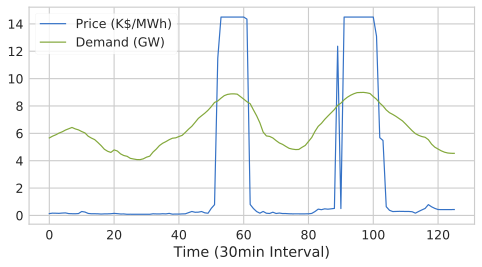

In [210]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(price_t, label="Price (K$/MWh)")
ax.plot(demand_t, label="Demand (GW)")
ax.set_xlabel("Time (30min Interval)")
ax.legend()

In [538]:
t_max = demand_t.shape[0]
c = price_t
A_ub = -np.tril(np.ones((t_max, t_max)))
b_ub = np.zeros(t_max)

In [539]:
sol = scipy.optimize.linprog(c=c, A_ub=A_ub, b_ub=b_ub,
                             bounds=t_max*[(-0.5, 0.125)])
sol

     fun: -142.81773139750027
 message: 'Optimization terminated successfully.'
     nit: 249
   slack: array([0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   , 1.125,
       1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875, 2.   , 2.125, 2.25 ,
       2.375, 2.5  , 2.625, 2.75 , 2.875, 3.   , 3.125, 3.25 , 3.375,
       3.5  , 3.625, 3.75 , 3.875, 4.   , 4.125, 4.25 , 4.375, 4.5  ,
       4.625, 4.75 , 4.875, 5.   , 5.125, 5.25 , 5.375, 5.5  , 5.625,
       5.75 , 5.875, 6.   , 6.125, 6.25 , 6.375, 6.5  , 6.625, 0.625,
       0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 2.25 ,
       2.375, 2.5  , 2.625, 2.75 , 2.875, 3.   , 3.125, 3.25 , 3.375,
       3.5  , 3.625, 3.75 , 3.875, 4.   , 4.125, 4.25 , 4.375, 4.5  ,
       4.625, 4.75 , 4.875, 5.   , 5.125, 5.25 , 5.375, 5.5  , 0.25 ,
       5.5  , 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625,
       0.625, 0.625, 0.625, 0.125, 0.125, 0.125, 0.125, 0.25 , 0.375,
       0.5  , 0.625, 0.75 , 0.875, 1.   , 1.125, 1.25 , 

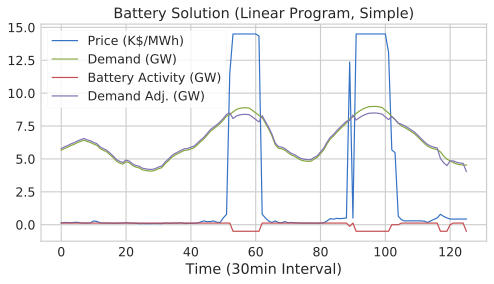

In [540]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Battery Solution (Linear Program, Simple)")
ax.plot(price_t, label="Price (K$/MWh)")
ax.plot(demand_t, label="Demand (GW)")
ax.plot(sol.x, label="Battery Activity (GW)")
# ax.plot(np.cumsum(sol.x), label="Battery Charge (GWh)")
ax.plot(demand_t + sol.x, label="Demand Adj. (GW)")
ax.set_xlabel("Time (30min Interval)")
ax.legend()

In [541]:
fig.savefig('battery-plot.png', dpi=150)

In [859]:
t_max = demand_t.shape[0]

discharge_max = 0.5
charge_max = 0.25
wear_cost = 1.0
battery_capacity = 4.0

c = np.concatenate([price_t + wear_cost, -price_t + wear_cost])
A_lb = np.hstack([np.tril(np.ones((t_max, t_max))), -np.tril(np.ones((t_max, t_max)))])
b_lb = np.zeros(t_max)

A_ub = np.hstack([np.tril(np.ones((t_max, t_max))), -np.tril(np.ones((t_max, t_max)))])
b_ub = battery_capacity*np.ones(t_max)

A_ub = np.vstack([-A_lb, A_ub])
b_ub = np.concatenate([b_lb, b_ub])

In [860]:
sol = scipy.optimize.linprog(c=c, A_ub=A_ub, b_ub=b_ub,
                             bounds=t_max*[(0.0, charge_max)] + t_max*[(0.0, discharge_max)])
sol

     fun: -101.51732090000002
 message: 'Optimization terminated successfully.'
     nit: 80
   slack: array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 2.75,
       3.  , 3.25, 3.25, 3.25, 3.25, 3.5 , 3.75, 4.  , 4.  , 4.  , 4.  ,
       4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 3.5 , 3.  ,
       2.5 , 2.  , 1.5 , 1.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25,
       0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75,
       3.  , 3.25, 3.5 , 3.75, 4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  ,
       4.  , 3.75, 4.  , 4.  , 3.5 , 3.  , 2.5 , 2.  , 1.5 , 1.  , 0.5 ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  ,
       4.  , 4.  , 4.

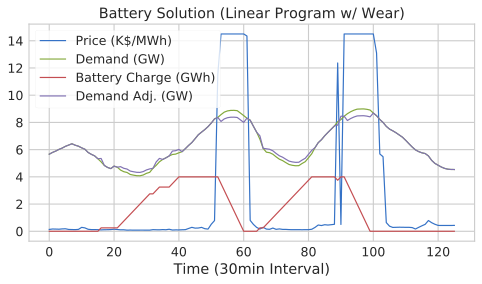

In [861]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Battery Solution (Linear Program w/ Wear)")
ax.plot(price_t, label="Price (K$/MWh)")
ax.plot(demand_t, label="Demand (GW)")
# ax.plot(sol.x[:t_max], label="Batt. Chg. Rate (GW)")
# ax.plot(sol.x[t_max:], label="Batt. Dischg Rate (GW)")
ax.plot(np.cumsum(sol.x[:t_max] - sol.x[t_max:]), label="Battery Charge (GWh)")
ax.plot(demand_t + sol.x[:t_max] - sol.x[t_max:], label="Demand Adj. (GW)")
ax.set_xlabel("Time (30min Interval)")
ax.legend()

In [862]:
fig.savefig('battery-plot2.png', dpi=150)

In [863]:
t_max = demand_t.shape[0]

discharge_max = 1.0
charge_max = 0.125
battery_capacity = 1.25
wear_cost = 0.5
peak_price = 1000.0
inv_peak_price = 1.0 / peak_price

A_lb = np.hstack([np.tril(np.ones((t_max, t_max))), -np.tril(np.ones((t_max, t_max)))])
b_lb = np.zeros(t_max)

A_ub = np.hstack([np.tril(np.ones((t_max, t_max))), -np.tril(np.ones((t_max, t_max)))])
b_ub = battery_capacity*np.ones(t_max)

A_ub = np.vstack([-A_lb, A_ub])
b_ub = np.concatenate([b_lb, b_ub])

c = np.concatenate([[1], inv_peak_price*(price_t + wear_cost), inv_peak_price*(-price_t + wear_cost)])
A_ub = np.block([[np.zeros((A_ub.shape[0], 1)), A_ub],
                 [-np.ones((t_max, 1)), np.identity(t_max), -np.identity(t_max)]])
b_ub = np.concatenate([b_ub, -demand_t])

In [864]:
sol = scipy.optimize.linprog(c=c, A_ub=A_ub, b_ub=b_ub,
                             bounds=[(0, None)] + t_max*[(0.0, charge_max)] + t_max*[(0.0, discharge_max)],
                             method='interior-point')
print(sol.message)
print(np.round(sol.fun / price_factor))

Optimization terminated successfully.
1743.0


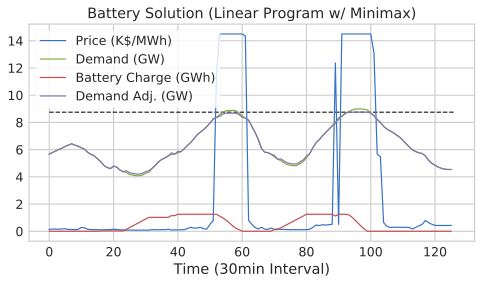

In [865]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Battery Solution (Linear Program w/ Minimax)")
ax.plot(price_t, label="Price (K$/MWh)")
ax.plot(demand_t, label="Demand (GW)")
# ax.plot(sol.x[1:t_max], label="Batt. Chg. Rate (GW)")
# ax.plot(sol.x[1+t_max:], label="Batt. Dischg Rate (GW)")
ax.plot(np.cumsum(sol.x[1:t_max+1] - sol.x[t_max+1:]), label="Battery Charge (GWh)")
ax.plot(demand_t + sol.x[1:t_max+1] - sol.x[t_max+1:], label="Demand Adj. (GW)")
ax.hlines(np.max(demand_t + sol.x[1:t_max+1] - sol.x[t_max+1:]), 0, t_max, linestyles='dashed')
ax.set_xlabel("Time (30min Interval)")
ax.legend()

In [866]:
fig.savefig('battery-plot-minimax.png', dpi=150)